In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from plyfile import PlyData, PlyElement
import sys

sys.path.append("..")
from data.utils import *
from data.load_raw_data import *

In [ ]:
points_main, leaves, semantics = load_real_ply_with_labels("/space/ariyanzarei/sorghum_segmentation/dataset/real_data/labeled/ply_files/PI_677914_1229_330749213440.ply")
pcd = create_ply_pcd_from_points_with_labels(points_main,leaves,False)
# o3d.visualization.draw_geometries([pcd])

In [ ]:
points = points_main[semantics==1]

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=2)
ax.set_xlabel("x: index 0")
ax.set_ylabel("y: index 1")
ax.set_zlabel("z: index 2")
plt.show()

In [1]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from sklearn.cluster import DBSCAN
from models.utils import SemanticMetrics, LeafMetrics
from data.utils import distinct_colors
from train_and_inference.predict_and_report_real_pcd import load_model
from data.load_raw_data import load_real_ply_with_labels, load_pcd_plyfile_new_approach

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
def real_data_semantic_segmentation(real_pcd_path):
    device_name = "cpu"
    device = torch.device(device_name)
    semantic_model = load_model("SorghumPartNetSemantic",-1)
    semantic_model = semantic_model.to(device)
    semantic_model.DGCNN_semantic_segmentor.device = device_name
    
    files = os.listdir(real_pcd_path)
    for file in files:
        path = os.path.join(real_pcd_path, file)
        points, instance_labels, semantic_labels = load_real_ply_with_labels(path)
        print(f":: Point cloud with {points.shape} points loaded. ")
        points = torch.tensor(points, dtype=torch.float64).to(device)
        if (
            "use_normals" in semantic_model.hparams
            and semantic_model.hparams["use_normals"]
        ):
            pred_semantic_label = semantic_model(torch.unsqueeze(points, dim=0).to(device))
        else:
            pred_semantic_label = semantic_model(
                torch.unsqueeze(points[:, :3], dim=0).to(device)
            )

        pred_semantic_label = F.softmax(pred_semantic_label, dim=1)
        pred_semantic_label = pred_semantic_label[0].cpu().detach().numpy().T
        pred_semantic_label_labels = np.argmax(pred_semantic_label, 1)

        metric_calculator = SemanticMetrics()
        acc = metric_calculator(
            torch.tensor(pred_semantic_label_labels), torch.tensor(semantic_labels)
        )

        colors = np.column_stack((pred_semantic_label_labels,pred_semantic_label_labels,pred_semantic_label_labels)).astype("float32")
        colors[colors[:,0]==0,:] = [0.3, 0.1, 0]
        colors[colors[:,0]==1,:] = [0, 0.7, 0]
        colors[colors[:,0]==2,:] = [0, 0, 0.7]

        fig = plt.figure(figsize=(15,15))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(points[:,0],points[:,1],points[:,2], s=2, c=colors)
        ax.set_xlabel("x: index 0")
        ax.set_ylabel("y: index 1")
        ax.set_zlabel("z: index 2")
        ax.set_title(f"Acc: {acc}")
        plt.savefig(f"{file.replace('.ply','')}_semantic.jpg",dpi=200)
        plt.show()
        print(acc)

def real_data_instance_segmentation(real_pcd_path):
    device_name = "cpu"
    device = torch.device(device_name)
    instance_model = load_model("SorghumPartNetInstance",-1)
    instance_model = instance_model.to(device)
    instance_model.DGCNN_feature_space.device = device_name
    
    files = os.listdir(real_pcd_path)
    for file in files:
        path = os.path.join(real_pcd_path, file)
        points, instance_labels, semantic_labels = load_real_ply_with_labels(path)
        points = points[semantic_labels == 1]
        instance_labels = instance_labels[semantic_labels == 1]
        points = torch.tensor(points, dtype=torch.float64).to(device)
        
        if (
            "use_normals" in instance_model.hparams
            and instance_model.hparams["use_normals"]
        ):
            pred_instance_features = instance_model(
                torch.unsqueeze(points, dim=0).to(device)
            )
        else:
            pred_instance_features = instance_model(
                torch.unsqueeze(points[:, :3], dim=0).to(device)
            )

        pred_instance_features = pred_instance_features.cpu().detach().numpy().squeeze()
        clustering = DBSCAN(eps=1, min_samples=10).fit(pred_instance_features)
        pred_final_cluster = clustering.labels_

        print("Number of predicted leaf instances: ", len(list(set(pred_final_cluster))))
        print("Number of ground truch leaf instances: ", len(list(set(instance_labels))))

        metric_calculator = LeafMetrics()
        acc, precison, recal, f1 = metric_calculator(
            torch.tensor(pred_final_cluster).unsqueeze(0).unsqueeze(-1),
            torch.tensor(instance_labels).unsqueeze(0).unsqueeze(-1),
        )

        d_colors = distinct_colors(len(list(set(pred_final_cluster))))
        colors = np.zeros((pred_final_cluster.shape[0],3))
        for i, l in enumerate(list(set(pred_final_cluster))):
            colors[pred_final_cluster == l, :] = d_colors[i]

        fig = plt.figure(figsize=(15,15))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(points[:,0],points[:,1],points[:,2], s=2, c=colors)
        ax.set_xlabel("x: index 0")
        ax.set_ylabel("y: index 1")
        ax.set_zlabel("z: index 2")
        ax.set_title(f"Acc: {acc} - Precision: {precison} - Recal: {recal} - F1: {f1}")
        plt.savefig(f"{file.replace('.ply','')}_instance.jpg",dpi=200)
        plt.show()
        

        print(":: Instance Predictions: ", acc, precison, recal, f1)

In [ ]:
real_data_semantic_segmentation("/space/ariyanzarei/sorghum_segmentation/dataset/real_data/labeled/ply_files")
real_data_instance_segmentation("/space/ariyanzarei/sorghum_segmentation/dataset/real_data/labeled/ply_files")

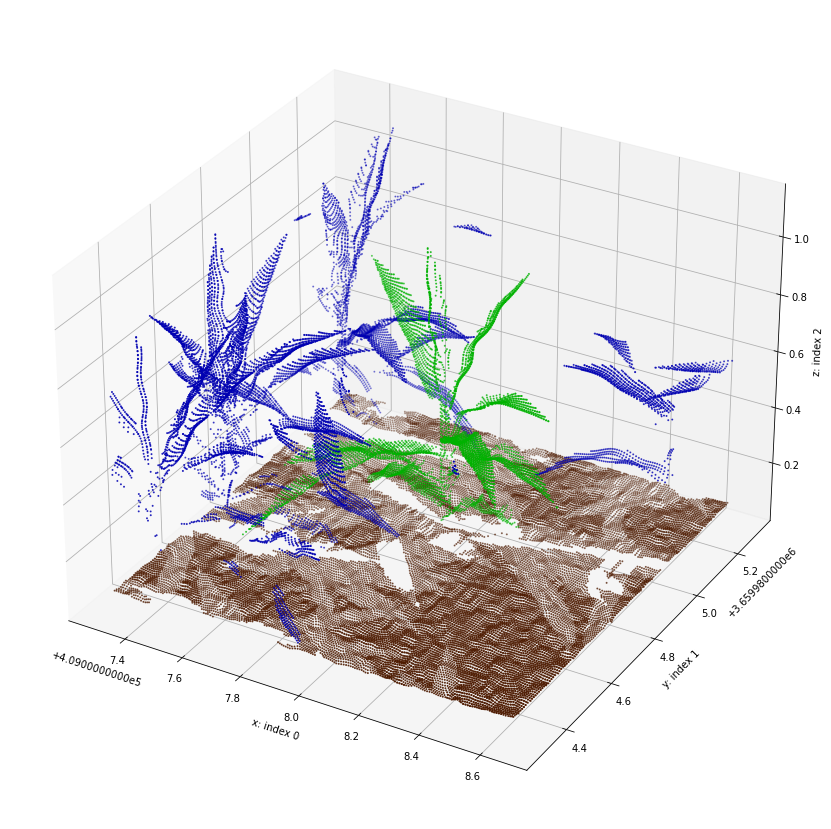

In [3]:
synthetic_pcd = load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/synthetic/2022-11-06/PointCloud/S11_61836.ply",False)
points = synthetic_pcd["points_full"]
labels = synthetic_pcd["labels_full"]

colors = np.column_stack((labels,labels,labels)).astype("float32")
colors[colors[:,0]==0,:] = [0.3, 0.1, 0]
colors[colors[:,0]==1,:] = [0, 0.7, 0]
colors[colors[:,0]==2,:] = [0, 0, 0.7]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=1, c=colors)
ax.set_xlabel("x: index 0")
ax.set_ylabel("y: index 1")
ax.set_zlabel("z: index 2")

plt.show()
